In [302]:
import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import LSTM, Dense, Dropout, Activation, BatchNormalization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy.random as rnd
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# convert an array of values into a dataset matrix
def create_dataset(trainX, trainY, look_back=1):
    dataX, dataY = [], []
    for i in range(len(trainX)-look_back-1):
        a = trainX[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(trainY[i + look_back-1])
    return np.array(dataX), np.array(dataY)

In [47]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005,
                      activation=tf.nn.elu, seed=42):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            activation=activation,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=None, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                #print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            if epoch % 500 == 0:
                print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

# Import WT    
x_train = np.genfromtxt('data/data_wt/sp500_wt.csv', delimiter=',', dtype=None, names=True)
x_train = [list(item) for item in x_train]
x_train = np.array(x_train)[:,2:]
print(x_train.shape)

def normalise_dataset(dataset):
    n_cols = dataset.shape[1]
    norm_dataset = np.zeros_like(dataset)
    for i in range(n_cols): 
        mean = np.sum(dataset[:,i])/len(dataset[:,i])
        std_dev = np.dot(dataset[:,i]-mean, dataset[:,i]-mean)/(len(dataset[:,i]) - 1)
        std_dev = np.sqrt(std_dev)
        norm_dataset[:,i] = (dataset[:,i] - mean) / std_dev

    return norm_dataset

# Normalised dataset
x_train = normalise_dataset(x_train)


(2079, 19)


In [40]:
def normalise_dataset(dataset):
    n_cols = dataset.shape[1]
    norm_dataset = np.zeros_like(dataset)
    for i in range(n_cols): 
        mean = np.sum(dataset[:,i])/len(dataset[:,i])
        std_dev = np.dot(dataset[:,i]-mean, dataset[:,i]-mean)/(len(dataset[:,i]) - 1)
        std_dev = np.sqrt(std_dev)
        norm_dataset[:,i] = (dataset[:,i] - mean) / std_dev

    return norm_dataset

In [23]:
# check this 
BATCH_SIZE = 60
N_EPOCHS = 2500
ACTIVATION = tf.nn.relu
LEARNING_RATE = 0.005

hidden_output1, W1, b1, W8, b8 = train_autoencoder(x_train, n_neurons=50, 
                                                   n_epochs=N_EPOCHS, 
                                                   batch_size=BATCH_SIZE, 
                                                   learning_rate=LEARNING_RATE,
                                                   activation=ACTIVATION)
hidden_output2, W2, b2, W7, b7 = train_autoencoder(hidden_output1, n_neurons=30, 
                                                   n_epochs=N_EPOCHS, 
                                                   batch_size=BATCH_SIZE, 
                                                   learning_rate=LEARNING_RATE,
                                                   activation=ACTIVATION)
hidden_output3, W3, b3, W6, b6 = train_autoencoder(hidden_output2, n_neurons=20, 
                                                   n_epochs=N_EPOCHS, 
                                                   batch_size=BATCH_SIZE, 
                                                   learning_rate=LEARNING_RATE,
                                                   activation=ACTIVATION)
o4, W4, b4, W5, b5 = train_autoencoder(hidden_output3,n_neurons=10, 
                                                   n_epochs=N_EPOCHS, 
                                                   batch_size=BATCH_SIZE, 
                                                   learning_rate=LEARNING_RATE,
                                                   activation=ACTIVATION)

0 Train MSE: 0.21456
500 Train MSE: 0.000275673
1000 Train MSE: 0.000188743
1500 Train MSE: 0.00021044
2000 Train MSE: 0.000485146
0 Train MSE: 0.238069
500 Train MSE: 0.000401362
1000 Train MSE: 0.000478527
1500 Train MSE: 0.000283563
2000 Train MSE: 0.000367953
0 Train MSE: 0.720427
500 Train MSE: 0.000360527
1000 Train MSE: 0.000473596
1500 Train MSE: 0.000615212
2000 Train MSE: 0.000513849
0 Train MSE: 2.11296
500 Train MSE: 0.0125729
1000 Train MSE: 0.0112613
1500 Train MSE: 0.00891299
2000 Train MSE: 0.00889777


In [30]:
np.savetxt("sae_test.csv", o4, delimiter=",", fmt='%-7.4f', 
              comments='')

In [62]:
from IPython.display import clear_output
# Live plot for loss during training
# Taken from: https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        # Reset the plot to only have the last 100 epochs
        if len(self.x) % 100 == 0:
            self.on_train_begin()
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [327]:
# Extract data from files
#latent_val = pd.read_csv('sae_output_5000.csv')

latent_val = pd.read_csv('data/sp500_index_data.csv')
latent_val = np.array(latent_val)
latent_val = normalise_dataset(latent_val)
print(latent_val.shape)
y_lazy = pd.read_csv('data/sp500_index_data.csv')['Close Price']
y_train = y_lazy.shift(-1)
#y_train = np.diff(y_lazy)
y_train = np.array(y_train)
#this means we have an na for the last value training is latent_val, target y_train

# Preparing the datasets with look_back parameters
look_back = 4
trainX_fixed = latent_val[:-1] # HAD TO DELETE "[:-1]" !
trainX_fixed = trainX_fixed[:,2:15]
print(trainX_fixed.shape)
trainX = trainX_fixed[:round(0.9*len(trainX_fixed))]
testX = trainX_fixed[round(0.9*len(trainX_fixed)):]

trainY_fixed = np.array(y_train[:-1]) #[1:]
trainY = trainY_fixed[:round(0.9*len(trainY_fixed))]
testY = trainY_fixed[round(0.9*len(trainY_fixed)):]

print("length testX + trainX: {}".format(len(testX)+len(trainX)))
print("length testY + trainY: {}".format(len(testY)+len(trainY)))

# Delete unnecessary arrays
del trainX_fixed
del trainY_fixed

trainX, trainY = create_dataset(trainX, trainY, look_back)
testX, testY = create_dataset(testX, testY, look_back) 


(2079, 21)
(2078, 13)
length testX + trainX: 2078
length testY + trainY: 2078


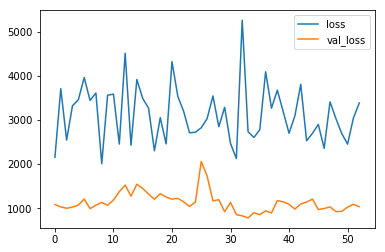

0s - loss: 3384.7987 - val_loss: 1033.6385
Epoch 754/2000


KeyboardInterrupt: 

In [328]:
# create and fit the LSTM network
LEARNING_RATE = 0.05/40
BATCH_SIZE = 60
EPOCHS = 2000
opti_adam = keras.optimizers.Adam(lr=LEARNING_RATE, decay=1e-5)
opti_sgd = keras.optimizers.SGD(lr=LEARNING_RATE)
opti_rmsprop = keras.optimizers.RMSprop(lr=LEARNING_RATE, decay=1e-6)
INPUT_SIZE = 13

model = Sequential()
#model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 10)))
#model.add(LSTM(20, input_shape=(look_back, 10)))
#model.add(Dropout(0.2, seed=42))
model.add(LSTM(INPUT_SIZE, return_sequences=True, input_shape=(look_back, INPUT_SIZE), unroll=True))
model.add(BatchNormalization())
model.add(LSTM(INPUT_SIZE, return_sequences=True, unroll=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(INPUT_SIZE, return_sequences=True, unroll=True))
model.add(BatchNormalization())
# model.add(LSTM(10, return_sequences=True, unroll=True))
# model.add(BatchNormalization())
model.add(LSTM(INPUT_SIZE, input_shape=(look_back, INPUT_SIZE), unroll=True, dropout=0.2))
model.add(BatchNormalization())
#model.add(LSTM(5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=opti_adam)
model.summary()
model.fit(trainX, trainY, epochs=EPOCHS, batch_size=BATCH_SIZE,
          verbose=2, callbacks=[plot_losses], validation_data=(testX, testY))

In [163]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_200 (LSTM)              (None, 4, 50)             14000     
_________________________________________________________________
lstm_201 (LSTM)              (None, 19)                5320      
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 20        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 19,340
Trainable params: 19,340
Non-trainable params: 0
_________________________________________________________________


[[ 2080.4753418 ]
 [ 2058.76391602]
 [ 2093.33984375]
 [ 2036.05480957]
 [ 2054.19213867]
 [ 2087.48046875]
 [ 2094.53344727]
 [ 2073.75170898]
 [ 2043.94311523]
 [ 2078.81811523]
 [ 2064.34863281]
 [ 2074.08325195]
 [ 2060.98803711]
 [ 2077.23657227]
 [ 2090.85546875]
 [ 2087.65722656]
 [ 2066.39794922]
 [ 2010.51257324]
 [ 2040.92333984]
 [ 2003.69396973]
 [ 1960.9095459 ]
 [ 1952.4765625 ]
 [ 1962.26013184]
 [ 1979.2097168 ]
 [ 1956.8885498 ]
 [ 1950.16589355]
 [ 1939.64038086]
 [ 1941.54736328]
 [ 1884.2331543 ]
 [ 1912.42370605]
 [ 1924.00744629]
 [ 1923.75219727]
 [ 1915.88317871]
 [ 1901.00683594]
 [ 1910.58728027]
 [ 1934.81835938]
 [ 1939.96948242]
 [ 1927.83093262]
 [ 1909.6940918 ]
 [ 1930.30175781]
 [ 1909.77612305]
 [ 1859.20446777]
 [ 1845.67138672]
 [ 1871.88623047]
 [ 1854.74047852]
 [ 1864.21203613]
 [ 1881.72180176]
 [ 1920.20690918]
 [ 1919.37512207]
 [ 1914.5435791 ]
 [ 1927.55273438]
 [ 1937.91699219]
 [ 1933.42150879]
 [ 1947.67834473]
 [ 1957.83239746]
 [ 1950.24

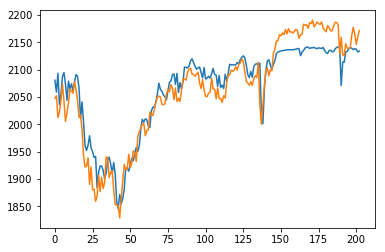

In [329]:
bugger = model.predict(testX)[:,0]
print(model.predict(testX))
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(bugger)
plt.plot(testY)
plt.show()

In [128]:
print(testX)

[[[ 1.37802517  1.3752418   1.39731245 ..., -0.82853044  2.13010982
   -0.26915804]
  [ 1.37802517  1.3752418   1.39731245 ..., -0.82853044  2.13010982
   -0.26915804]
  [ 1.32796338  1.34887     1.35243761 ..., -1.19482752  2.00598144
   -0.25441169]
  [ 1.32796338  1.34887     1.35243761 ..., -1.19482752  2.00598144
   -0.25441169]]

 [[ 1.37802517  1.3752418   1.39731245 ..., -0.82853044  2.13010982
   -0.26915804]
  [ 1.32796338  1.34887     1.35243761 ..., -1.19482752  2.00598144
   -0.25441169]
  [ 1.32796338  1.34887     1.35243761 ..., -1.19482752  2.00598144
   -0.25441169]
  [ 1.32796338  1.34887     1.35243761 ..., -1.19482752  2.00598144
   -0.25441169]]

 [[ 1.32796338  1.34887     1.35243761 ..., -1.19482752  2.00598144
   -0.25441169]
  [ 1.32796338  1.34887     1.35243761 ..., -1.19482752  2.00598144
   -0.25441169]
  [ 1.32796338  1.34887     1.35243761 ..., -1.19482752  2.00598144
   -0.25441169]
  [ 1.32796338  1.34887     1.35243761 ..., -1.19482752  2.00598144
   -

202
202


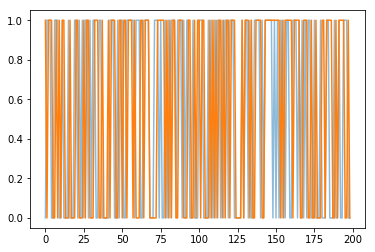

In [330]:
diff_bugger = np.diff(bugger)
diff_bugger = [1 if x > 0 else 0 for x in diff_bugger]
diff_trainY = np.diff(testY)
diff_trainY = [1 if x > 0 else 0 for x in diff_trainY]
print(len(diff_trainY))
print(len(diff_bugger))
plt.plot(diff_trainY[1:200], alpha = 0.5)
plt.plot(diff_bugger[1:200])
plt.show()

In [335]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(diff_trainY, diff_trainY, labels=[0,1])[0,0])
print(confusion_matrix(diff_trainY, diff_trainY, labels=[0,1])[1,1]/np.trace(confusion_matrix(diff_trainY, diff_trainY, labels=[0,1])))
conf_mat = confusion_matrix(diff_bugger, diff_trainY, labels=[0,1])
print(conf_mat)
print("Accuracy price move prediction: {}".format(np.trace(conf_mat) / np.sum(conf_mat)))

95
0.529702970297
[[36 54]
 [59 53]]
Accuracy price move prediction: 0.4405940594059406


In [332]:
def compute_mape(y, y_pred):
    assert len(y) == len(y_pred)
    return np.sum(np.abs((y-y_pred) / y)) / len(y)

def compute_r(y, y_pred):
    assert len(y) == len(y_pred)
    mean_pred = np.mean(y_pred)
    return  np.dot(y - mean_pred, y_pred - mean_pred) / np.sqrt(np.sum(np.square(y - mean_pred)) * np.sum(np.square(y_pred - mean_pred)))

def compute_theil_u(y, y_pred):
    assert len(y) == len(y_pred)
    
    n = len(y)
    temp = np.sqrt(np.sum(np.square(y)) / n)
    temp += np.sqrt(np.sum(np.square(y_pred)) / n)
    temp = np.sqrt(np.sum(np.square(y - y_pred)) / n) / temp 
    return temp
    
    
print(compute_mape(testY, bugger))
print(compute_r(testY, bugger))
print(compute_theil_u(testY, bugger))

0.0123328134696
0.946351718341
0.0075845741614


In [333]:
BUY_COST = 0.25/100
SELL_COST = 0.45/100

def daily_pnl(y_tomorrow, y_today, buy=True, buy_cost=BUY_COST, sell_cost=SELL_COST):
    if(buy):
        return (y_tomorrow - y_today + (sell_cost*y_tomorrow + buy_cost*y_today)) / y_today
    else:
        return (y_today - y_tomorrow + (sell_cost*y_today + buy_cost*y_tomorrow)) / y_today
    

def strategy_return(y_pred, y_truth):
    assert len(y_pred) == len(y_truth)
    n = len(y_pred)
    # Vector of 1s for buy, 0s for sell. Approx: no exact predictions...
    buy_sell = [1 if y_pred[index] > y_truth[index] else -1 if y_pred[index] < y_truth[index] else 0 for index in range(n-1)]
    ret = [daily_pnl(y_truth[index+1], y_truth[index]) if buy_sell[index] == 1 else
           daily_pnl(y_truth[index+1], y_truth[index], buy=False) for index in range(n-1)]
    return np.sum(ret)*100
    

In [334]:
strategy_return(bugger, testY)
#print((bugger - testY)[0:20])

160.35856942372959